In [1]:
import pandas as pd
import numpy as np
seed = 7
np.random.seed(seed)
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import seaborn as sns
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Dropout,GlobalMaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [2]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():

    image_path = ("/kaggle/input/oddata/XML")
    print(image_path)
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('labels.csv', index=None)
    print('Successfully converted xml to csv.')


main()

/kaggle/input/oddata/XML
Successfully converted xml to csv.


In [3]:
df = pd.read_csv('/kaggle/working/labels.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,twohundred_99.jpg,224,224,200,59,18,144,205
1,IMG_0473.jpg,224,224,5,51,15,210,214
2,IMG_0360.jpg,224,224,5,31,53,212,153
3,twohundred_233.jpg,224,224,200,47,37,175,188
4,fifty_544.jpg,224,224,50,17,53,211,163


In [4]:
df.shape

(5128, 8)

In [5]:
# df = df[df['filename'].isin(os.listdir('/kaggle/input/finalcv/train/images'))]

In [6]:
df = df.drop(columns=['width', 'height'])

In [7]:
path = '/kaggle/input/oddata/Images/'
df['filename'] = path + df['filename'].astype(str)
df.head()

,filename,class,xmin,ymin,xmax,ymax
0,/kaggle/input/oddata/Images/twohundred_99.jpg,200,59,18,144,205
1,/kaggle/input/oddata/Images/IMG_0473.jpg,5,51,15,210,214
2,/kaggle/input/oddata/Images/IMG_0360.jpg,5,31,53,212,153
3,/kaggle/input/oddata/Images/twohundred_233.jpg,200,47,37,175,188
4,/kaggle/input/oddata/Images/fifty_544.jpg,50,17,53,211,163


In [8]:
df = df.drop_duplicates(subset='filename', keep="first")

In [9]:
df.shape

(5081, 6)

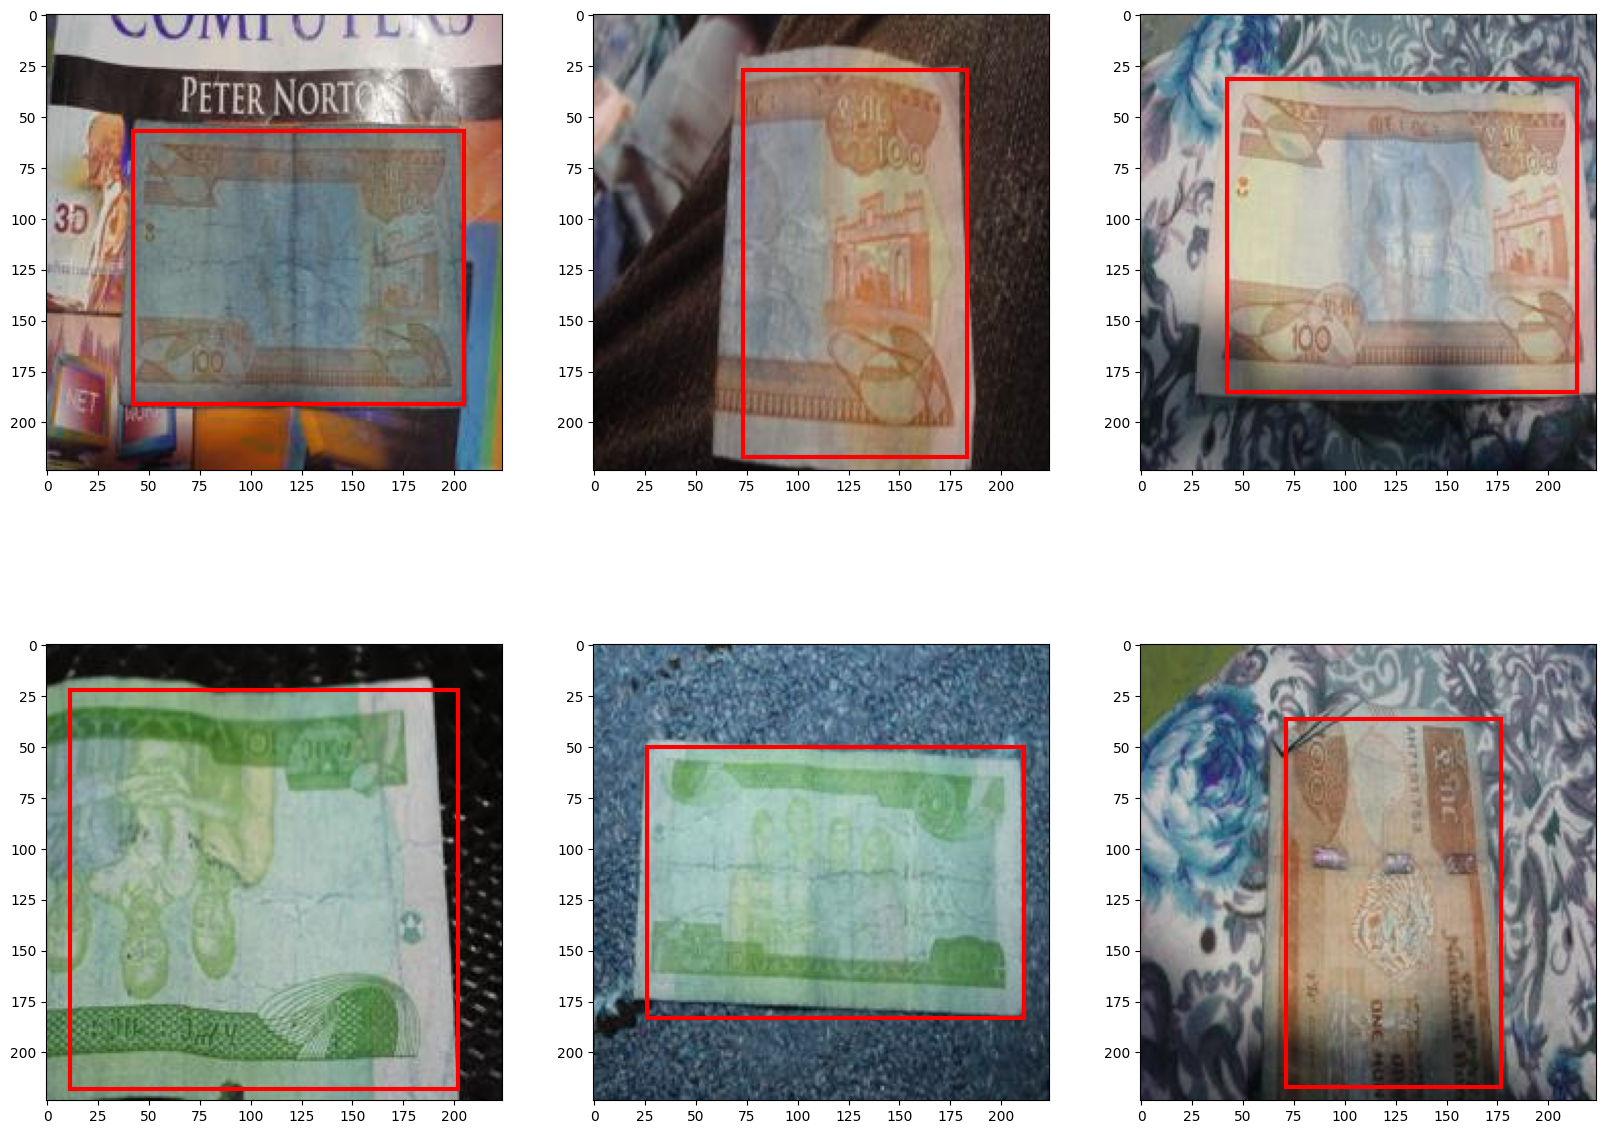

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))

for i, r in enumerate(random.sample(range(len(df)), 6)):
    row = df.iloc[r]
    #im = np.array(Image.open(row['filename']), dtype=np.uint8)
    im = cv2.imread(row['filename'])
    ax[int(i/3), i%3].imshow(im)
    
    for _, instance in df[(df['filename']==row['filename'])].iterrows():
        # Create a Rectangle patch
        rect = patches.Rectangle((instance['xmin'], instance['ymin']), instance['xmax'] - instance['xmin'], 
                                  instance['ymax'] - instance['ymin'], linewidth=3, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax[int(i/3), i%3].add_patch(rect)

In [11]:
def filter_rows_by_values(df , col, values):
    return df[~df[col].isin(values)]

In [12]:
df = filter_rows_by_values(df, 'filename', ['/kaggle/input/oddata/Images/IMG_0965.jpg'])

In [13]:
df['class'].value_counts()

class
5      1032
50     1025
100    1018
200    1016
10      989
Name: count, dtype: int64

In [14]:
SAMPLE_SIZE = 950
df_five = df[df['class'] == 5].sample(SAMPLE_SIZE, random_state=42)
df_ten = df[df['class'] == 10].sample(SAMPLE_SIZE, random_state=42)
df_fifty = df[df['class'] == 50].sample(SAMPLE_SIZE, random_state=42)
df_hundred = df[df['class'] == 100].sample(SAMPLE_SIZE, random_state=42)
df_twohundred = df[df['class'] == 200].sample(SAMPLE_SIZE, random_state=42)
# Concatenate the two dfs and shuffle them up
train = sklearn.utils.shuffle(pd.concat([df_five, df_ten, df_fifty, df_hundred, df_twohundred], axis=0).reset_index(drop=True))

train.shape

(4750, 6)

In [15]:
test = df[ ~df.index.isin(train.index)]

In [16]:
test.head()

,filename,class,xmin,ymin,xmax,ymax
4750,/kaggle/input/oddata/Images/twohundred_186.jpg,200,99,51,218,203
4751,/kaggle/input/oddata/Images/IMG_0476.jpg,5,42,69,200,217
4752,/kaggle/input/oddata/Images/fifty_731.jpg,50,38,80,165,213
4753,/kaggle/input/oddata/Images/IMG_0590.jpg,5,8,74,118,189
4754,/kaggle/input/oddata/Images/fifty_297.jpg,50,9,58,218,192


In [17]:
test.shape

(376, 6)

In [18]:
train.head()

,filename,class,xmin,ymin,xmax,ymax
3510,/kaggle/input/oddata/Images/hundred_228.jpg,100,44,59,200,194
1524,/kaggle/input/oddata/Images/ten_656.jpg,10,14,57,92,173
2921,/kaggle/input/oddata/Images/hundred_597.jpg,100,36,35,200,156
2114,/kaggle/input/oddata/Images/fifty_900.jpg,50,73,73,150,192
687,/kaggle/input/oddata/Images/IMG_0823.jpg,5,53,22,183,218


In [19]:
# df = filter_rows_by_values(df)

In [20]:
train, valid = train_test_split(df, test_size=0.2)
#test, valid = train_test_split(test,  test_size=0.5)

In [21]:
train.shape

(4064, 6)

In [22]:
valid.shape

(1016, 6)

In [23]:
def generate_inputs(df):
    """
    """
    images = []
    labels = []
    boxes = []
    for index, row in df.iterrows():
        img = row['filename']
        box = row[2:6]
        box = [int(x)/224 for x in box]
        input_image = cv2.imread(img)
        #print(box[:4])
#         if os.path.isfile(img):
#             input_image = cv2.imread(img)
#         else:
#             continue
        #input_image = cv2.resize(input_image,(224,224))
        images.append(input_image)
        labels.append(row['class'])
        boxes.append(box)
    boxes = np.array(boxes, dtype= 'float32')
    images = np.array(images)
    images = images.astype('float32') / 255.0
    return images, labels, boxes

In [24]:
train_images, train_labels, train_boxes = generate_inputs(train)
# test_images, test_labels, test_boxes = generate_inputs(test)
valid_images, valid_labels, valid_boxes = generate_inputs(valid)

In [25]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
valid_labels = le.fit_transform(valid_labels)
train_labels = tf.keras.utils.to_categorical(train_labels)
valid_labels = tf.keras.utils.to_categorical(valid_labels)
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

In [26]:
print("shape of images ", train_images.shape)
print("shape of boxes ", train_boxes.shape)
print("shape of class ", train_labels.shape)

shape of images  (4064, 224, 224, 3)
shape of boxes  (4064, 4)
shape of class  (4064, 5)


In [27]:
num_classes = 5
num_box = 4

In [28]:
x = x_input = layers.Input(shape=(224,224,3))
x = Conv2D(16, (3,3), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), padding='same', activation = 'relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(units = 256, activation = 'relu')(x)
x = Dropout(rate = 0.2)(x)
x_box = Dense(num_box, activation='sigmoid', name = 'bounding_box')(x)
x_cls = Dense(num_classes, activation='softmax', name = 'class_label')(x)
x = (x_box, x_cls)
model = tf.keras.models.Model(x_input, x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      4,640 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 401408)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 102,760,7… │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bounding_box        │ (None, 4)         │      1,028 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_label (Dense) │ (None, 5)         │      1,285 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,860,777 (392.38 MB)

 Trainable params: 102,860,617 (392.38 MB)

 Non-trainable params: 160 (640.00 B)

In [31]:
losses = {
    'class_label': 'categorical_crossentropy',
    'bounding_box': 'mean_squared_error'
}

In [32]:
metrics = {
    'class_label': 'accuracy', 
    'bounding_box':  'mse'
    }

In [33]:
loss_weights = {
    'class_label': 1.0,
    'bounding_box': 1.0
}

In [34]:
train_y = {
    "class_label": train_labels,
    "bounding_box": train_boxes
}

valid_y = {
    'class_label': valid_labels,
    'bounding_box': valid_boxes
}

In [35]:
early_stopping=EarlyStopping(monitor='val_loss', patience=5,start_from_epoch=3,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=2, min_lr=1e-10, min_delta=0.0004, mode='min')

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss=losses,
              metrics=metrics,
             loss_weights = loss_weights)
epochs = 30
history = model.fit(train_images, train_y,
       epochs = epochs,
       batch_size = 32,
       callbacks = [early_stopping, reduce_lr],
       verbose = 1, validation_data= (valid_images, valid_y))

Epoch 1/30


I0000 00:00:1727110261.100137   36483 service.cc:145] XLA service 0x7ce5900040d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727110261.100193   36483 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/127 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - bounding_box_mse: 0.1373 - class_label_accuracy: 0.3247 - loss: 2.0996

I0000 00:00:1727110274.805744   36483 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - bounding_box_mse: 0.0427 - class_label_accuracy: 0.6087 - loss: 1.0716 - val_bounding_box_mse: 0.0782 - val_class_label_accuracy: 0.3031 - val_loss: 1.5989 - learning_rate: 1.0000e-06
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - bounding_box_mse: 0.0261 - class_label_accuracy: 0.9221 - loss: 0.2800 - val_bounding_box_mse: 0.0418 - val_class_label_accuracy: 0.2825 - val_loss: 1.4760 - learning_rate: 1.0000e-06
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - bounding_box_mse: 0.0250 - class_label_accuracy: 0.9719 - loss: 0.1584 - val_bounding_box_mse: 0.0212 - val_class_label_accuracy: 0.5758 - val_loss: 0.9723 - learning_rate: 1.0000e-06
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - bounding_box_mse: 0.0230 - class_label_accuracy: 0.9821 - loss: 0.1075 - val_bounding_box_mse: 0.0127 - val_class_label_accuracy: 0.8986 - val_loss: 0.3648 - learning_rate: 1.0000e-06
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step -

In [37]:
def plot(var1, var2, plot_name):
    # Get the loss metrics from the trained model
    c1 = history.history[var1]
    c2 = history.history[var2]

    epochs = range(len(c1))

    # Plot the metrics
    plt.style.use("ggplot")
    plt.plot(epochs, c1, 'b', label=var1)
    plt.plot(epochs, c2, 'r', label=var2)
    plt.title(str(plot_name))
    plt.savefig(str(plot_name)+'.png')
    plt.legend(['Training', 'Validation'])

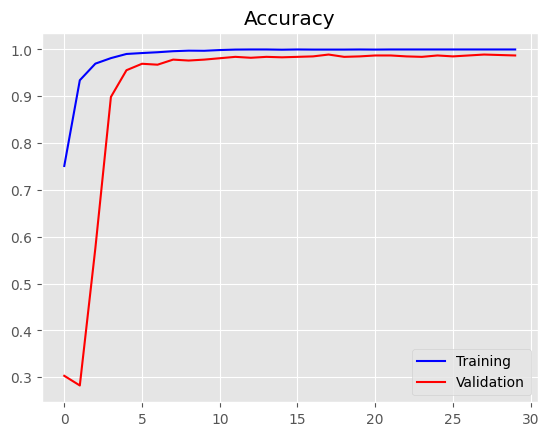

In [38]:
plot('class_label_accuracy', 'val_class_label_accuracy','Accuracy')

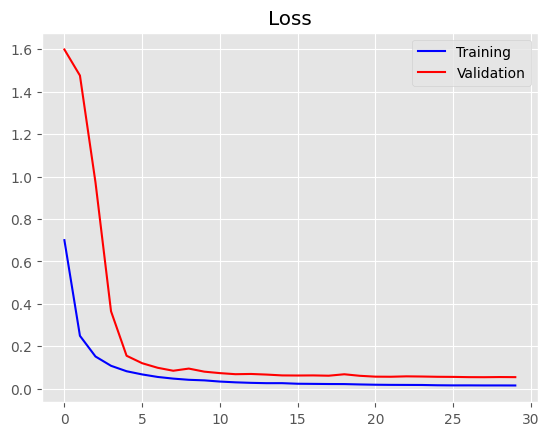

In [39]:
plot('loss', 'val_loss','Loss')

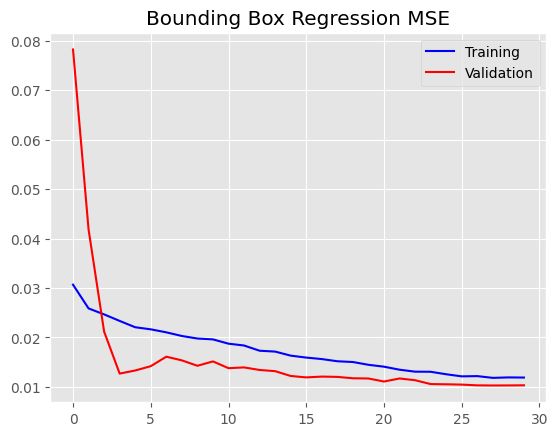

In [40]:
plot( 'bounding_box_mse', 'val_bounding_box_mse','Bounding Box Regression MSE')

In [41]:
le.inverse_transform([0,1,2,3,4])

array([  5,  10,  50, 100, 200])

In [42]:
classes_list = [ 5,  10,  50, 100, 200]

In [43]:
# Enter your class names in this list
global label_names

# Must be same as the Annotations list we used
label_names = sorted(classes_list)

In [44]:
# This function will preprocess images.
def preprocess(img, image_size = 224):
  
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0 

    # Expand dimensions as predict expect image in batches
    image = np.expand_dims(image, axis=0) 
    return image

In [45]:
def postprocess(image, results):

    # Split the results into class probabilities and box coordinates
    bounding_box, class_probs = results

    # First let's get the class label

    # The index of class with the highest confidence is our target class
    class_index = np.argmax(class_probs)
  
    # Use this index to get the class name.
    class_label = label_names[class_index]

    # Now you can extract the bounding box too.

    # Get the height and width of the actual image
    h, w = image.shape[:2]

    # Extract the Coordinates
    x1, y1, x2, y2 = bounding_box[0]

    # Convert the coordinates from relative (i.e. 0-1) to actual values
    x1 = int(w * x1)
    x2 = int(w * x2)
    y1 = int(h * y1)
    y2 = int(h * y2)

    # return the lable and coordinates
    return class_label, (x1,y1,x2,y2),class_probs

In [46]:
# We will use this function to make prediction on images.
def predict(image, scale = 0.5, show=True):
  
    # Before we can make a prediction we need to preprocess the image.
    processed_image = preprocess(image)

    # Now we can use our model for prediction
    results = model.predict(processed_image)

    # Now we need to postprocess these results.
    # After postprocessing, we can easily use our results
    label, (x1, y1, x2, y2), confidence = postprocess(image, results)
    
    if show:
        # Now annotate the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 100), 1)
        cv2.putText(
                    image, 
                    '{}'.format(label, confidence), 
                    (x1, y2 + int(1 * scale)), 
                    cv2.FONT_HERSHEY_COMPLEX, scale,
                    (0, 255, 100),
                    1
                    )

        # Show the Image with matplotlib
        plt.figure(figsize=(10,10))
        plt.imshow(image[:,:,::-1])
    return label

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


5

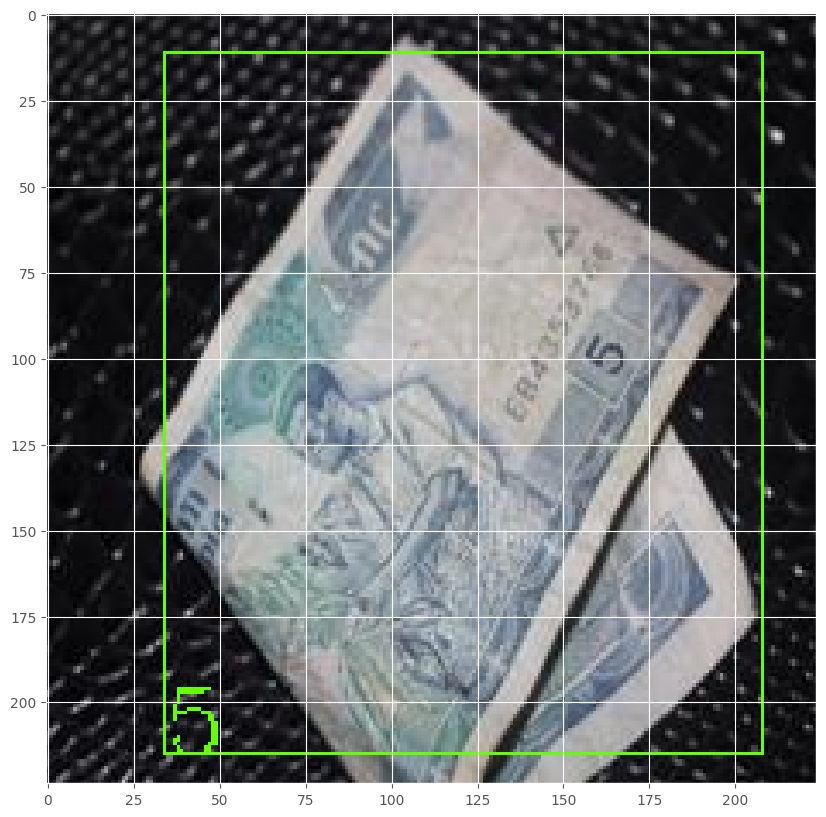

In [47]:
image = cv2.imread('/kaggle/input/finalcv/test/images/IMG_0010.jpg' )
predict(image, scale = 0.9)

In [48]:
y_hat = []
for f_name in test.loc[:,'filename']:
#     img = cv2.imread(f_name)
    if os.path.isfile(f_name):
           img = cv2.imread(f_name)
    else:
        continue
    result_img = predict(img, scale = 1.5, show=False)
    y_hat.append(result_img)
    
y_hat = np.array(y_hat, dtype=int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [49]:
y_test = np.array(test.loc[:,'class'])

              precision    recall  f1-score   support

           5       0.97      1.00      0.99        69
          10       0.98      0.78      0.87        82
          50       0.68      0.78      0.73        64
         100       0.64      0.65      0.65        75
         200       0.95      1.00      0.97        86

    accuracy                           0.85       376
   macro avg       0.85      0.84      0.84       376
weighted avg       0.85      0.85      0.85       376
 



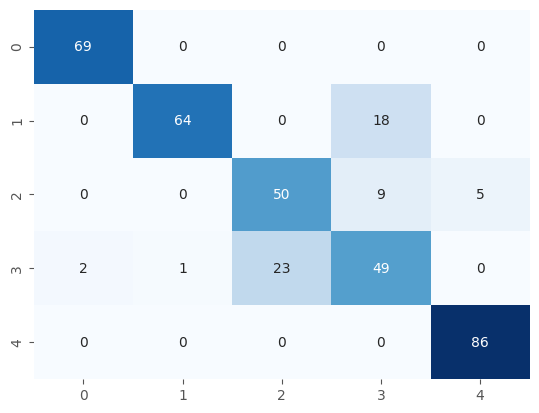

In [50]:
print(classification_report(y_test, y_hat), '\n')
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False, )
plt.show()

In [62]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [51]:
# !rm -rf /kaggle/working/*

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [73]:
import pickle
import visualkeras
from collections import defaultdict

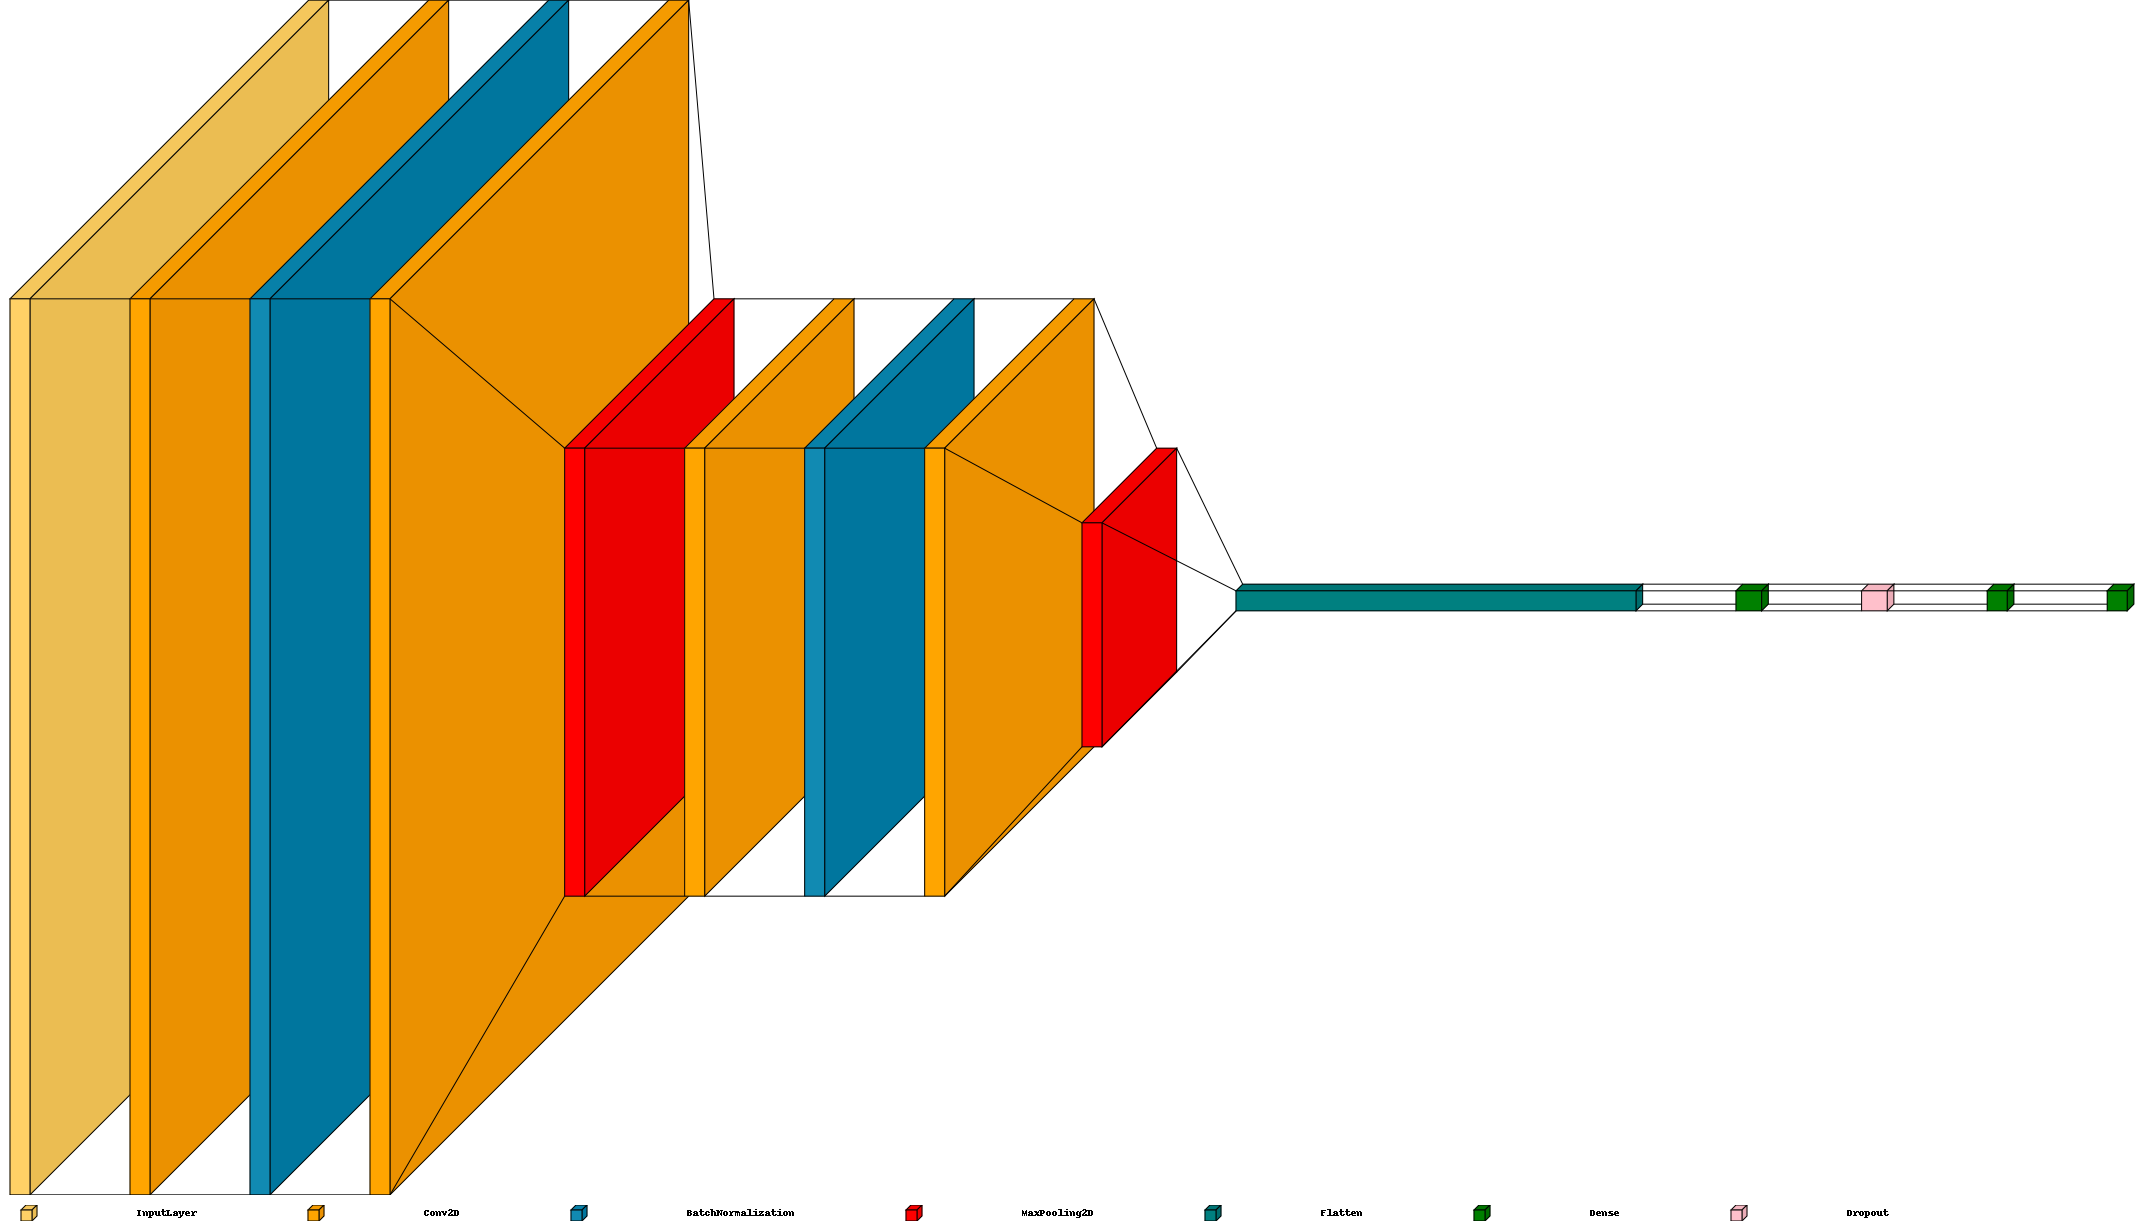

In [81]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
#color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model,legend=True, to_file='visualkeras1.png',color_map=color_map, spacing=100)

In [68]:
model.save('notefy.h5')
f = open('le.pickle', 'wb')
f.write(pickle.dumps(le))
f.close()

In [69]:
result = history.history
result = pd.DataFrame(result)
result.to_csv('cnn.csv')

In [85]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'notephy.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [86]:
zip_dir()

/kaggle/working/notephy.zip